In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 41kB/s 
     |████████████████████████████████| 3.8MB 20.4MB/s 
     |████████████████████████████████| 450kB 42.4MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.9.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
!git clone https://github.com/Behtash-BehinAein/spatial_temporal_1.git spatial_temporal_1 
%cd spatial_temporal_1 
!ls

Cloning into 'spatial_temporal_1'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
/content/spatial_temporal_1
README.md	  userB_trips.json  userD_trips.json
userA_trips.json  userC_trips.json


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Destination Prediction')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install holidays
!pip install geopy
!pip install pygeohash

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6163 sha256=7a177a3627d955dfa86371c1ed0ce6ce98f1417452f5eedd0abfb1c6d5a63a79
  Stored in directory: /root/.cache/pip/wheels/3f/5f/14/989d83a271207dda28232746d63e737a2dbd88ea7f7a9db807
Successfully built pygeohash


# Import pertinent libraries

In [0]:
import os, sys
from pathlib import Path
import pickle
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import holidays
import pygeohash as gh
##import Geohash as gh
from geopy import distance          # Used only to benchmark custom-defined function 
import matplotlib.pyplot as plt
import datetime 
from sklearn.ensemble import RandomForestClassifier as RFC
#from xgboost import XGBClassifier as XGBC
plt.style.use(['dark_background'])   # This notebook was written in Jupyterlab with dark theme 
from  dp_utils import *

In [0]:
%load_ext autoreload
%autoreload 2

# Note on data size , usage of Pandas and vectorization
    - If data size gets too large, we could do some or all of data preprocessing with PySpark
        - The choice also depends on how we are to scale. In particular, it appears each user's data has to be processed independently
        - For example, one can use Keras/tensorflow generators to load certain number of files at a time   
    - Although some functions used here could readily be implemented in plain python, pandas was used as much as possible because of its vectorization capabilities to make the data processing faster
    - When convenient, numpy vectorization has been used as well for custom-defined functions

# Running pipeline ...
    - Access the dataset and user files

In [7]:
dataset, userFiles = access_dataset(Path('/content/spatial_temporal_1')); userFiles.sort()
display(dataset, userFiles)

PosixPath('/content/spatial_temporal_1')

['userA_trips', 'userB_trips', 'userC_trips', 'userD_trips']

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys

In [8]:
dataset, userFiles = access_dataset(Path('/content/spatial_temporal_1')); userFiles.sort()
# ======================================================== Old/New
userTrips = dataset_to_user_dict(dataset, userFiles)     
show = [display('-'*100, key, val.head(1)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,id,start_timezone,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_timezone,end_location_lat,end_location_lon,end_location_name
0,A-id-683,America/Los_Angeles,2019-01-01 00:54:00,2019-01-01 01:08:05,37.398685,-121.976898,"4655 Great America Pkwy, Santa Clara CA 95054",America/Los_Angeles,37.373428,-122.052521,"610 Grape Ave, Sunnyvale CA 94086"


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,id,start_timezone,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_timezone,end_location_lat,end_location_lon,end_location_name
0,B-id-610,America/Los_Angeles,2019-01-01 11:31:57,2019-01-01 12:06:19,37.249821,-121.790237,"94 Limewell Ct, San Jose CA 95138",America/Los_Angeles,37.233299,-122.062111,"Gaetti Road, Saratoga CA 95070"


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,id,start_timezone,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_timezone,end_location_lat,end_location_lon,end_location_name
0,C-id-648,America/Los_Angeles,2019-01-03 09:21:08,2019-01-03 09:24:39,37.768478,-121.91954,"1078 S Wedgewood Rd, San Ramon CA 94582",America/Los_Angeles,37.774185,-121.923256,"11000 Bollinger Canyon Road, San Ramon CA 94582"


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,id,start_timezone,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_timezone,end_location_lat,end_location_lon,end_location_name
0,D-id-514,America/Los_Angeles,2019-01-22 08:28:39,2019-01-22 08:47:41,37.765411,-121.893539,"12995 Harcourt Way, San Ramon CA 94582",America/Los_Angeles,37.707798,-121.873016,"The Shops, Pleasanton CA 94588"


# Data Types

In [10]:
print('Data types','-'*50)
display(userTrips[userFiles[0]].info())

Data types --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 11 columns):
id                     684 non-null object
start_timezone         684 non-null object
start_time             684 non-null datetime64[ns]
end_time               684 non-null datetime64[ns]
start_location_lat     684 non-null float32
start_location_lon     684 non-null float32
start_location_name    684 non-null object
end_timezone           684 non-null object
end_location_lat       684 non-null float32
end_location_lon       684 non-null float32
end_location_name      684 non-null object
dtypes: datetime64[ns](2), float32(4), object(5)
memory usage: 48.2+ KB


None

# Inspect the date-range for all users 
    - Here, data is more or less consistent
    - Currently, not part of the pipeline, for inspection only 
    - More complicated dataset may require preprocessing for dataranges 
        - If so, a function can be added to dp_utils.py

In [0]:
def getDateRange(df):
    '''
    - Take in a dataframe a
    - Returns
        - The earliest and latest dates in the timestamps | type: Pandas timestamp
    '''
    first_date = df['start_time'].iloc[0].date().strftime('%m-%d-%y')
    last_date  = df['end_time'].iloc[-1].date().strftime('%m-%d-%y')
    return first_date, last_date    

for user in userFiles:
    display(user , getDateRange(userTrips[user]))
    print('=='*15)
    

'userA_trips'

('01-01-19', '05-30-19')

'userB_trips'

('01-01-19', '05-30-19')

'userC_trips'

('01-03-19', '05-30-19')

'userD_trips'

('01-22-19', '05-30-19')

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be used for train/validation split

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = dataset_to_user_dict(dataset, userFiles)  
# ======================================================== Old/New
lastMonth = getLastMonth(userFiles, userTrips)         
show = [display(key + f' last month: {val}') for key,val in lastMonth.items() ]

'userA_trips last month: 5'

'userB_trips last month: 5'

'userC_trips last month: 5'

'userD_trips last month: 5'

# Ensure that start and end time zones are the same for each user 
    - Here, start and end time zones are the same for all users 
    - Currently, not part of the pipeline, for inspection only 
    - More complicated dataset may require preprocessing here 

In [0]:
checkTimeZone(userFiles, userTrips) # If there is timezone incompatiability, errors will appear below 

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users

In [0]:
dataset, userFiles = access_dataset(Path('dataset/')) 
userTrips = dataset_to_user_dict(dataset, userFiles)  
lastMonth = getLastMonth(userFiles, userTrips)        
# ======================================================== Old/New
original = userTrips[userFiles[0]].columns
dropList = ['id','start_timezone', 'end_timezone']
userTrips = drop_cols(userFiles, userTrips, dropList)    
new = userTrips[userFiles[0]].columns
print('Original cols:', [i for i in original])
print('New cols     :', [i for i in new])
print('Dropped cols :', [i for i in dropList])

Original cols: ['id', 'start_timezone', 'start_time', 'end_time', 'start_location_lat', 'start_location_lon', 'start_location_name', 'end_timezone', 'end_location_lat', 'end_location_lon', 'end_location_name']
New cols     : ['start_time', 'end_time', 'start_location_lat', 'start_location_lon', 'start_location_name', 'end_location_lat', 'end_location_lon', 'end_location_name']
Dropped cols : ['id', 'start_timezone', 'end_timezone']


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values

In [0]:
dataset, userFiles = access_dataset(Path('dataset/')) 
userTrips = dataset_to_user_dict(dataset, userFiles)  
lastMonth = getLastMonth(userFiles, userTrips)     
dropList = ['id','start_timezone', 'end_timezone']; userTrips = drop_cols(userFiles, userTrips, dropList)   
# ======================================================== Old/New
userTrips = addGeohash(userFiles, userTrips, precision= 6) # Maximum error:  5: 2.4Km | 6: 0.61Km | 7: 0.076Km  | 8: 0.019Km
show = [display('-'*100, key, val.head(1)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-01 00:54:00,2019-01-01 01:08:05,37.398685,-121.976898,"4655 Great America Pkwy, Santa Clara CA 95054",37.373428,-122.052521,"610 Grape Ave, Sunnyvale CA 94086",9q9kb2,9q9hwe


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-01 11:31:57,2019-01-01 12:06:19,37.249821,-121.790237,"94 Limewell Ct, San Jose CA 95138",37.233299,-122.062111,"Gaetti Road, Saratoga CA 95070",9q97ut,9q95y6


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-03 09:21:08,2019-01-03 09:24:39,37.768478,-121.91954,"1078 S Wedgewood Rd, San Ramon CA 94582",37.774185,-121.923256,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qce,9q9qcs


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-22 08:28:39,2019-01-22 08:47:41,37.765411,-121.893539,"12995 Harcourt Way, San Ramon CA 94582",37.707798,-121.873016,"The Shops, Pleasanton CA 94588",9q9qf4,9q9qd8


# Inspection: unique geohashes 
    - This is mostly just a general check
    - It also begs the question to ask for stats on geohash frequencies 

In [0]:
for user in userFiles:
    print(user, 'start unique geohashes: ' , len(userTrips[user]['start_location_geohash'].unique()), '| total: ',  len(userTrips[user]['start_location_geohash']) )
    print(user, 'end unique geohashes:   ' , len(userTrips[user]['end_location_geohash'].unique()), '| total: ',    len(userTrips[user]['end_location_geohash']) )  
    print('--'*10)

userA_trips start unique geohashes:  69 | total:  684
userA_trips end unique geohashes:    69 | total:  684
--------------------
userB_trips start unique geohashes:  56 | total:  611
userB_trips end unique geohashes:    56 | total:  611
--------------------
userC_trips start unique geohashes:  71 | total:  649
userC_trips end unique geohashes:    70 | total:  649
--------------------
userD_trips start unique geohashes:  73 | total:  515
userD_trips end unique geohashes:    69 | total:  515
--------------------


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Unify lat,lon values based on common geohashes 
        - Depending on geohashes being start or end, there might be a few 'm' distance difference but that will not affect the model
            - Model will be build based on geohashes
            - Use of trip distances is for processing, analysis and visualization 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/')) 
userTrips = dataset_to_user_dict(dataset, userFiles)  
lastMonth = getLastMonth(userFiles, userTrips)     
dropList = ['id','start_timezone', 'end_timezone']; userTrips = drop_cols(userFiles, userTrips, dropList)   
userTrips = addGeohash(userFiles, userTrips, precision= 6) # Maximum error: 5:2.4Km |  6: 0.61Km | 7: 0.076Km  | 8: 0.019Km
userTrips = unifyLatLon(userFiles,userTrips)
# ======================================================== Old/New
show = [display('-'*100, key, val.head(1)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-01 00:54:00,2019-01-01 01:08:05,37.39838,-121.976433,"4655 Great America Pkwy, Santa Clara CA 95054",37.373932,-122.054558,"610 Grape Ave, Sunnyvale CA 94086",9q9kb2,9q9hwe


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-01 11:31:57,2019-01-01 12:06:19,37.249866,-121.790337,"94 Limewell Ct, San Jose CA 95138",37.234386,-122.062302,"Gaetti Road, Saratoga CA 95070",9q97ut,9q95y6


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-03 09:21:08,2019-01-03 09:24:39,37.767647,-121.917366,"1078 S Wedgewood Rd, San Ramon CA 94582",37.77441,-121.922783,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qce,9q9qcs


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash
0,2019-01-22 08:28:39,2019-01-22 08:47:41,37.765411,-121.893539,"12995 Harcourt Way, San Ramon CA 94582",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qf4,9q9qd8


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Unify lat,lon based on shared geohash 
        - Replaces all common with the average of all common 
    - Add trip duration in min : whole minutes are used. Anything below 1min is set to 0
        - Used for diagnostic, analysis, various data processing

In [0]:
dataset, userFiles = access_dataset(Path('dataset/')) 
userTrips = dataset_to_user_dict(dataset, userFiles)  
lastMonth = getLastMonth(userFiles, userTrips)     
dropList = ['id','start_timezone', 'end_timezone']; userTrips = drop_cols(userFiles, userTrips, dropList)   
userTrips = addGeohash(userFiles, userTrips, precision= 6) # Maximum error:   6: 0.61Km | 7: 0.076Km  | 8: 0.
userTrips = unifyLatLon(userFiles,userTrips)
# ======================================================== Old/New
userTrips = addTripDur(userFiles, userTrips)         
show = [display('-'*100, key, val.head(1)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min
0,2019-01-01 00:54:00,2019-01-01 01:08:05,37.39838,-121.976433,"4655 Great America Pkwy, Santa Clara CA 95054",37.373932,-122.054558,"610 Grape Ave, Sunnyvale CA 94086",9q9kb2,9q9hwe,14


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min
0,2019-01-01 11:31:57,2019-01-01 12:06:19,37.249866,-121.790337,"94 Limewell Ct, San Jose CA 95138",37.234386,-122.062302,"Gaetti Road, Saratoga CA 95070",9q97ut,9q95y6,34


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min
0,2019-01-03 09:21:08,2019-01-03 09:24:39,37.767647,-121.917366,"1078 S Wedgewood Rd, San Ramon CA 94582",37.77441,-121.922783,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qce,9q9qcs,3


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min
0,2019-01-22 08:28:39,2019-01-22 08:47:41,37.765411,-121.893539,"12995 Harcourt Way, San Ramon CA 94582",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qf4,9q9qd8,19


# Diagnostic: calculate trip geodesic distances in Km
    - Not used for ML pipeline here, but used for benchamarking another method
        - Geopy based distance calculation cannot easily be vectorized 
            - We have tried np.vectorize() method but its impact is not significant  
        - Instead, a numpy based great circle distance can be used. see next 

In [0]:
%time vectorized_distance_geodesic(userTrips[userFiles[0]]['start_location_lat'], userTrips[userFiles[0]]['start_location_lon'],\
                                   userTrips[userFiles[0]]['end_location_lat'], userTrips[userFiles[0]]['end_location_lon'])[:5]

CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 569 ms


array([ 7.432, 11.236,  6.995,  8.437,  8.766])

# Diagnostic: calculate trip great-circle distances in Km 
    - This is a good approximation to geodesic distance 
    - It is faster because of numpy vectorization
        - For userA, e.g., this is ~30x faster
    - With more time, geodesic distance can also be numpy vectorized if needed

In [0]:
print('Great-circle distance [Km]:')
%time display(distanceGreatCircle(userTrips[userFiles[0]]['start_location_lat'], userTrips[userFiles[0]]['start_location_lon'],\
                        userTrips[userFiles[0]]['end_location_lat'], userTrips[userFiles[0]]['end_location_lon'])[:5].to_list())
print('\nGeodesic distance [Km]:\n[7.338, 11.085, 6.99, 8.436, 8.624]')

Great-circle distance [Km]:


[7.418, 11.217, 7.006, 8.445, 8.773]

CPU times: user 13 ms, sys: 55 µs, total: 13 ms
Wall time: 30 ms

Geodesic distance [Km]:
[7.338, 11.085, 6.99, 8.436, 8.624]


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Unify lat,lon based on shared geohash 
        - Replaces all common with the average of all common 
    - Add trip duration in min : whole minutes are used. Anything below 1min is set to 0
        - Used for diagnostic, analysis, various data processing
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing


In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = dataset_to_user_dict(dataset, userFiles)   
lastMonth = getLastMonth(userFiles, userTrips)        
dropList = ['id','start_timezone', 'end_timezone']; userTrips = drop_cols(userFiles, userTrips, dropList) 
userTrips = addGeohash(userFiles, userTrips, precision= 6) # Maximum error: 5:2.4Km  6: 0.61Km | 7: 0.076Km  | 8: 0.019Km
userTrips = unifyLatLon(userFiles,userTrips)
userTrips = addTripDur(userFiles, userTrips)          
# ======================================================== Old/New
userTrips = addTripDis(userFiles, userTrips)        

# Insepction of the trip distance and duration

- (1) Sorted by distance 
    - NOTE: Here, trip distances with start,end location in the same geohash HAVE BEEN SET TO ZERO
        - The idea is that the model will have accuracy corresponding to geohash size
        - One justification could be that model prediction is of little use for trips within a geohash:
            - Users may not even want the model to predict a distinct end location from their starting point if their end location is only 500m-600m away 
            - This is an assumption; as such it can be modified after discussion
    - There are long round trips to the same geohash
    - There are very short trips within a geohash

In [0]:
show = [display('='*160, key, val.sort_values(by=['tripDis_Km']).head(5)) for key,val in userTrips.items()]

'================================================================================================================================================================'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
181,2019-02-08 07:27:39,2019-02-08 07:31:33,37.353302,-121.957390,"1722 Hillebrant Place, Santa Clara CA 95050",37.353302,-121.957390,"1722 Hillebrant Place, Santa Clara CA 95050",9q9k2z,9q9k2z,3,0.0
344,2019-03-22 18:46:41,2019-03-22 18:48:35,37.352154,-121.961906,"2161 El Camino Real, Santa Clara CA 95050",37.352154,-121.961906,"2225 El Camino Real, Santa Clara CA 95050",9q9k2x,9q9k2x,1,0.0
24,2019-01-05 21:59:34,2019-01-05 22:01:46,37.529182,-121.980202,"4829 Porter Street, Fremont CA 94538",37.529182,-121.980202,"4829 Porter Street, Fremont CA 94538",9q9m2r,9q9m2r,2,0.0
378,2019-03-30 13:07:59,2019-03-30 13:09:32,37.360939,-121.961166,"2090 Scott Blvd, Santa Clara CA 95050",37.360939,-121.961166,"2090 Scott Blvd, Santa Clara CA 95050",9q9k89,9q9k89,1,0.0
110,2019-01-27 15:49:21,2019-01-27 15:54:35,37.352154,-121.961906,"Mccormick Drive, Santa Clara CA 95050",37.352154,-121.961906,"2215 El Camino Real, Santa Clara CA 95050",9q9k2x,9q9k2x,5,0.0


'================================================================================================================================================================'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
590,2019-05-27 11:29:07,2019-05-27 11:32:37,37.024944,-121.564484,"8620 San Ysidro Ave, Gilroy CA 95020",37.024944,-121.564484,"8435 San Ysidro Avenue, Gilroy CA 95020",9q9d9s,9q9d9s,3,0.0
23,2019-01-08 15:23:53,2019-01-08 15:26:45,37.230148,-121.775909,"122 Bernal Rd, San Jose CA 95119",37.230148,-121.775909,"117 Bernal Rd, San Jose CA 95119",9q97uc,9q97uc,2,0.0
478,2019-04-27 17:37:15,2019-04-27 17:40:26,37.244587,-121.786697,"5858 Little Ave, San Jose CA 95123",37.244587,-121.786697,"Great Oaks Boulevard, San Jose CA 95119",9q97us,9q97us,3,0.0
229,2019-02-25 08:34:38,2019-02-25 08:35:37,37.235863,-121.846962,"768 Glenside Drive, San Jose CA 95123",37.235863,-121.846962,"784 Glenside Drive, San Jose CA 95123",9q97g6,9q97g6,0,0.0
380,2019-03-31 17:30:09,2019-03-31 17:31:45,37.239483,-121.774422,"6050 Monterey Rd, San Jose CA 95138",37.239483,-121.774422,"6050 Monterey Rd, San Jose CA 95138",9q97ug,9q97ug,1,0.0


'================================================================================================================================================================'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
324,2019-03-26 13:13:52,2019-03-26 13:14:53,37.774300,-121.922737,"11060 Bollinger Canyon Rd, Danville CA 94506",37.774300,-121.922737,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qcs,9q9qcs,1,0.0
396,2019-04-08 17:51:21,2019-04-08 17:51:52,37.767647,-121.917366,"3143 Sweetviolet Dr, San Ramon CA 94582",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,0,0.0
399,2019-04-09 07:54:12,2019-04-09 08:08:26,37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,14,0.0
400,2019-04-09 08:23:14,2019-04-09 08:53:14,37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,30,0.0
403,2019-04-09 16:15:03,2019-04-09 17:07:07,37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,52,0.0


'================================================================================================================================================================'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
68,2019-02-09 20:38:39,2019-02-09 20:46:50,37.771641,-121.946747,"350 Bollinger Canyon Ln, San Ramon CA 94582",37.771641,-121.946747,"500 Bollinger Canyon Way, San Ramon CA 94582",9q9qch,9q9qch,8,0.0
89,2019-02-15 20:08:39,2019-02-15 21:26:26,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",9q9qct,9q9qct,77,0.0
399,2019-04-26 17:51:03,2019-04-26 17:51:58,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",9q9qct,9q9qct,0,0.0
419,2019-05-02 08:15:56,2019-05-02 08:45:08,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",9q9qct,9q9qct,29,0.0
194,2019-03-11 20:51:51,2019-03-11 20:52:45,37.774441,-121.922295,"11000 Bollinger Canyon Rd, Danville CA 94506",37.774441,-121.922295,"11060 Bollinger Canyon Rd, Danville CA 94506",9q9qcs,9q9qcs,0,0.0


- (2) Sorted by trip duration
    - There are very short trips that nonetheless cross a geohash into neighborig one
        - See, e.g. ,  rows 574 and 454 for userA below 
    - One additional denoising can be resetting ( * ) one geohash equal to the other based on which one is most occuring if start and end geohash are too close
        - The justification again would be that the trip distance is too small and model prediction of a distinct end location is of little use 
        - Here, having distinct geohashes is just an artifact of imposing a mathematical grid of geohashes over user trips
            - Rather than a mathematical approach, we'd like to have a user-utility approach
                - In general, a semantic meaning can be associated with the geohashes, e.g., work or home
                - It might also be possible to efficiently learn embeddings for similar geolocations
                    - One would have to try learning-embeddings to see how well it works
        - ( * ) Rather than this resetting, we can also add features that will include the distances to the top-"n" most occuring geohashes for all start locations 
            - We will add these features, but for deep-learning approaches, geohash resetting and/or location-proximities as features 
              may not be needed as embeddings will be derived 

In [0]:
show = [display('='*160, key, val.sort_values(by=['tripDur_min']).head(5)) for key,val in userTrips.items()]

'================================================================================================================================================================'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
455,2019-04-13 19:13:38,2019-04-13 19:14:07,37.353302,-121.957390,"1786 Hillebrant Place, Santa Clara CA 95050",37.353302,-121.957390,"1786 Hillebrant Place, Santa Clara CA 95050",9q9k2z,9q9k2z,0,0.000000
574,2019-05-06 10:01:53,2019-05-06 10:02:39,37.353817,-121.957748,"1831 Hillebrant Place, Santa Clara CA 95050",37.353306,-121.957375,"1786 Hillebrant Place, Santa Clara CA 95050",9q9k8b,9q9k2z,0,0.065979
646,2019-05-22 20:31:49,2019-05-22 20:32:30,37.353302,-121.957390,"1601 Civic Center Drive, Santa Clara CA 95050",37.353302,-121.957390,"1601 Civic Center Drive, Santa Clara CA 95050",9q9k2z,9q9k2z,0,0.000000
454,2019-04-12 19:30:06,2019-04-12 19:30:58,37.353302,-121.957390,"1902 Hillebrant Pl, Santa Clara CA 95050",37.353825,-121.957802,"1934 Hillebrant Place, Santa Clara CA 95050",9q9k2z,9q9k8b,0,0.067993
442,2019-04-10 10:05:22,2019-04-10 10:05:56,37.353302,-121.957390,"1601 Civic Center Dr, Santa Clara CA 95050",37.353302,-121.957390,"1786 Hillebrant Place, Santa Clara CA 95050",9q9k2z,9q9k2z,0,0.000000


'================================================================================================================================================================'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
433,2019-04-14 15:03:03,2019-04-14 15:03:55,37.244587,-121.786697,"5858 Little Ave, San Jose CA 95119",37.244587,-121.786697,"5858 Little Ave, San Jose CA 95119",9q97us,9q97us,0,0.0
229,2019-02-25 08:34:38,2019-02-25 08:35:37,37.235863,-121.846962,"768 Glenside Drive, San Jose CA 95123",37.235863,-121.846962,"784 Glenside Drive, San Jose CA 95123",9q97g6,9q97g6,0,0.0
232,2019-02-25 12:01:08,2019-02-25 12:01:55,37.235863,-121.846962,"741 Sunset Glen Drive, San Jose CA 95123",37.235863,-121.846962,"6138 Chesbro Avenue, San Jose CA 95123",9q97g6,9q97g6,0,0.0
251,2019-03-02 12:56:18,2019-03-02 12:57:05,37.249866,-121.790337,"89 Limewell Court, San Jose CA 95138",37.249866,-121.790337,"94 Limewell Ct, San Jose CA 95138",9q97ut,9q97ut,0,0.0
380,2019-03-31 17:30:09,2019-03-31 17:31:45,37.239483,-121.774422,"6050 Monterey Rd, San Jose CA 95138",37.239483,-121.774422,"6050 Monterey Rd, San Jose CA 95138",9q97ug,9q97ug,1,0.0


'================================================================================================================================================================'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
396,2019-04-08 17:51:21,2019-04-08 17:51:52,37.767647,-121.917366,"3143 Sweetviolet Dr, San Ramon CA 94582",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,0,0.0
463,2019-04-15 15:47:12,2019-04-15 15:48:11,37.767647,-121.917366,"3599 Cinnamon Ridge Rd, San Ramon CA 94582",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,0,0.0
481,2019-04-16 21:44:39,2019-04-16 21:45:16,37.767647,-121.917366,"3143 Sweetviolet Dr, San Ramon CA 94582",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,0,0.0
379,2019-04-07 12:50:24,2019-04-07 12:51:04,37.774300,-121.922737,"N Wedgewood Rd, Danville CA 94506",37.774300,-121.922737,"11060 Bollinger Canyon Rd, Danville CA 94506",9q9qcs,9q9qcs,0,0.0
34,2019-01-12 18:03:36,2019-01-12 18:04:00,37.774300,-121.922737,"11060 Bollinger Canyon Rd, Danville CA 94506",37.774300,-121.922737,"N Wedgewood Rd, Danville CA 94506",9q9qcs,9q9qcs,0,0.0


'================================================================================================================================================================'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km
139,2019-02-23 18:28:36,2019-02-23 18:29:03,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",9q9qct,9q9qct,0,0.0
246,2019-03-27 07:53:10,2019-03-27 07:53:47,37.778660,-121.919395,"1709 Campanula Drive, San Ramon CA 94582",37.778660,-121.919395,"1709 Campanula Drive, San Ramon CA 94582",9q9qct,9q9qct,0,0.0
111,2019-02-17 21:32:57,2019-02-17 21:33:41,37.458412,-121.909637,"127 Dixon Rd, Milpitas CA 95035",37.458412,-121.909637,"127 Dixon Rd, Milpitas CA 95035",9q9m1g,9q9m1g,0,0.0
508,2019-05-29 08:10:45,2019-05-29 08:11:06,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",9q9qct,9q9qct,0,0.0
272,2019-04-02 09:35:29,2019-04-02 09:35:56,37.700413,-121.874161,"4335 Rosewood Dr, Pleasanton CA 94588",37.700413,-121.874161,"4341 Rosewood Drive, Pleasanton CA 94588",9q9q6x,9q9q6x,0,0.0


# Visualization of start and end locations

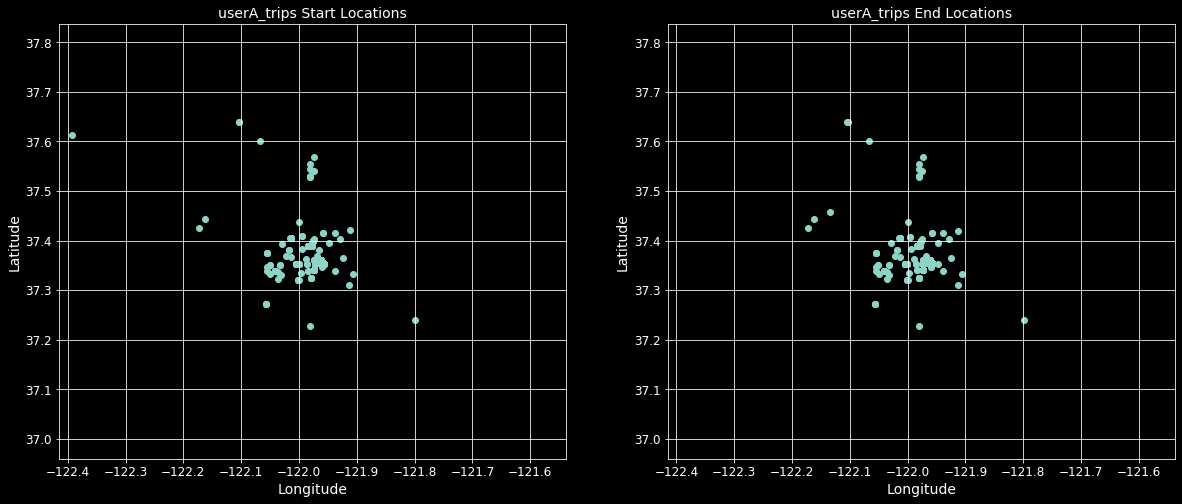

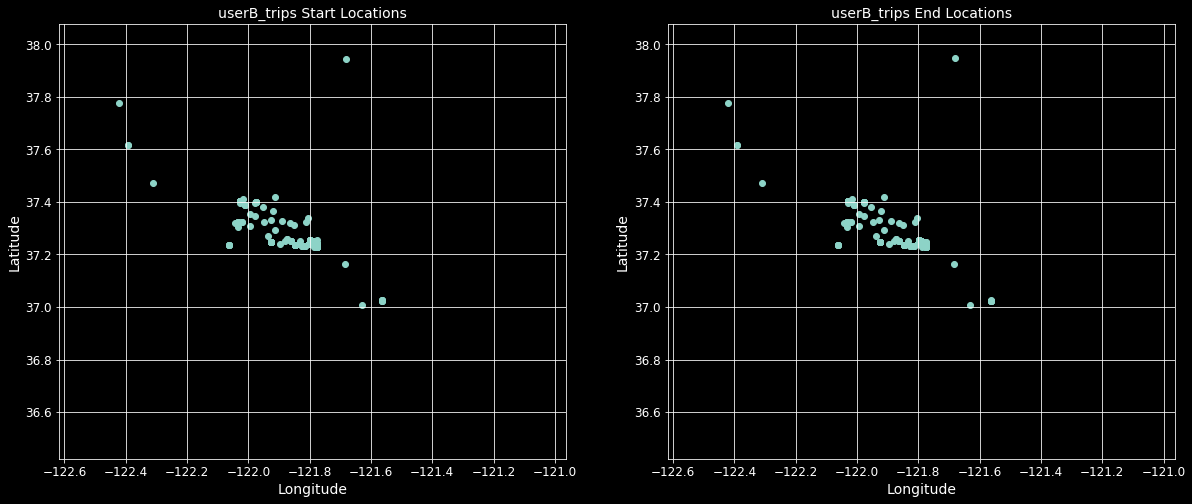

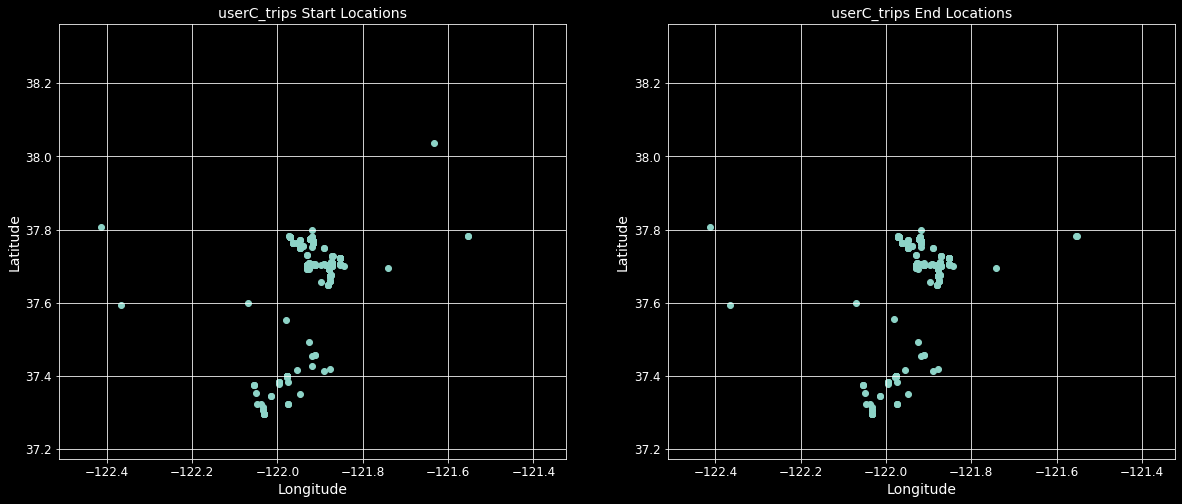

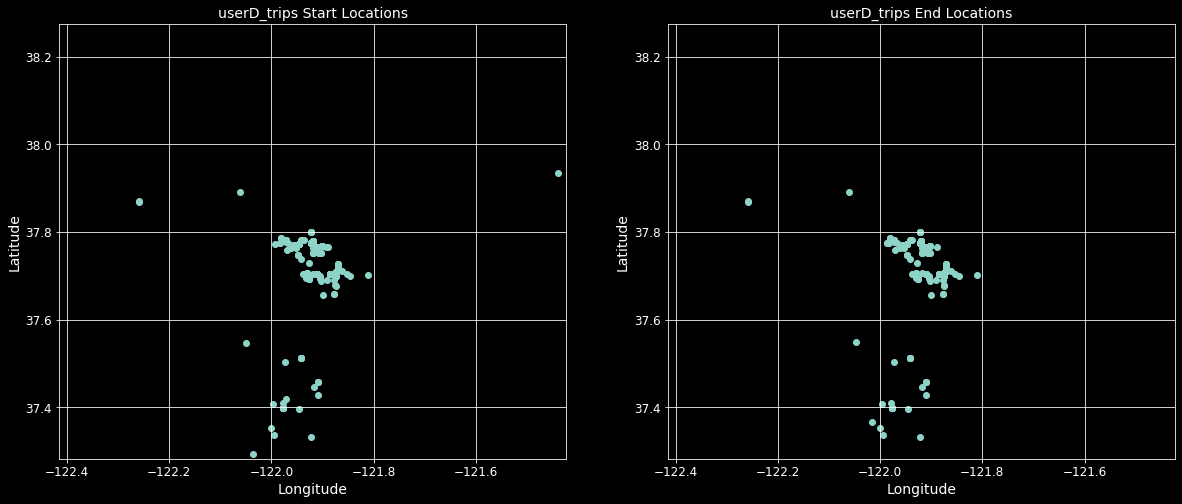

In [0]:
for user in userFiles: 
    
    # Calculate maximum distance traveled for each user 
    maxDistanceKm  = np.max(userTrips[user]['tripDis_Km'])
    maxDistanceDeg = maxDistanceKm / 100
        
    # Find the most common starting place (name-based) -------------------------
    # Get the lat, lon for this place 
    center = userTrips[user]['start_location_name'].mode()[0]    
    centerLat = userTrips[user][userTrips[user]['start_location_name'] == center]['start_location_lat'].values[0]
    centerLon = userTrips[user][userTrips[user]['start_location_name'] == center]['start_location_lon'].values[0]
    #print(centerLon , centerLat)

    # Define geoboundaries for each user 
    latLow = centerLat - maxDistanceDeg
    latHigh = centerLat+ maxDistanceDeg
    lonLow = centerLon - maxDistanceDeg
    lonHigh = centerLon+ maxDistanceDeg

    # ----------------------------------------------------------------------------------
    # Ensure that the geoboundaries contain all geolocations of each user 
    minLat = min(np.min(userTrips[user]['start_location_lat']) , np.min(userTrips[user]['end_location_lat']))
    maxLat = max(np.max(userTrips[user]['start_location_lat']) , np.max(userTrips[user]['end_location_lat']))        
    minLon = min(np.min(userTrips[user]['start_location_lon']) , np.min(userTrips[user]['end_location_lon']))
    maxLon = max(np.max(userTrips[user]['start_location_lon']) , np.max(userTrips[user]['end_location_lon']))

    assert latLow  <= minLat    
    assert latHigh >= maxLat 
    assert lonLow  <= minLon    
    assert lonHigh >= maxLon 
    # ----------------------------------------------------------------------------------
    fig = plt.figure(figsize=(20,8))

    fig.add_subplot(1, 2, 1 )
    plt.scatter(userTrips[user][['start_location_lon']] ,userTrips[user][['start_location_lat']] )
    plt.title(user +' Start Locations', fontsize=14)
    plt.xlabel('Longitude', fontsize=14)    
    plt.ylabel('Latitude', fontsize=14)
    plt.xlim([lonLow, lonHigh])
    plt.ylim([latLow, latHigh])
    plt.tick_params(labelsize=12)
    plt.grid()  
    
    fig.add_subplot(1, 2, 2 )
    plt.scatter(userTrips[user][['end_location_lon']] ,userTrips[user][['end_location_lat']] )
    plt.title(user +'End Locations', fontsize=14)
    plt.xlabel('Longitude', fontsize=14)    
    plt.ylabel('Latitude', fontsize=14)
    plt.xlim([lonLow, lonHigh])
    plt.ylim([latLow, latHigh])
    plt.tick_params(labelsize=12)
    plt.grid()  
    
    plt.title(user +' End Locations', fontsize=14)

    


# Visualize trip durations and distances : distribitions using hist

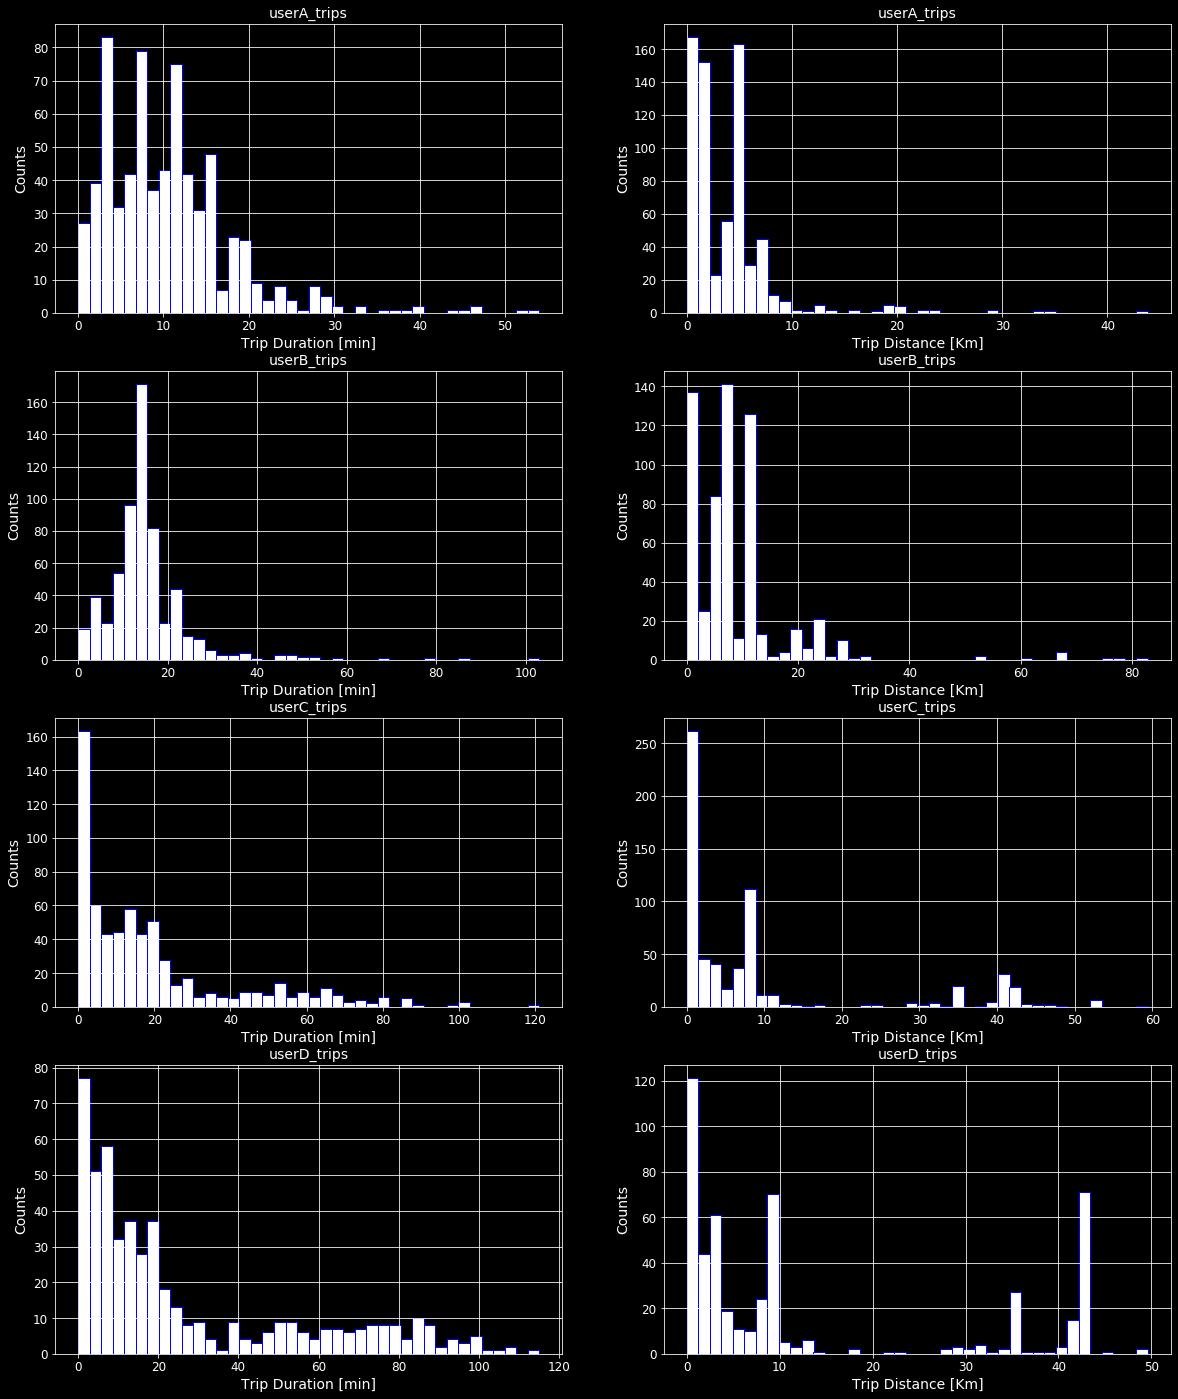

In [0]:
fig = plt.figure(figsize=(20,50))
n_plts = 2*len(userFiles)
n_cols = 2
n_rows = n_plts

j=0
for i in range(n_plts):
    if i%2 == 0:
        fig.add_subplot(n_rows, n_cols, i+1 )
        plt.hist(userTrips[userFiles[j]]['tripDur_min'], bins=40, color='w', edgecolor='b')
        plt.xlabel('Trip Duration [min]', fontsize=14)
    # ----------------------------------
    if i%2 != 0:    
        fig.add_subplot(n_rows, n_cols, i+1 )
        plt.hist(userTrips[userFiles[j]]['tripDis_Km'], bins=40, color='w', edgecolor='b')
        plt.xlabel('Trip Distance [Km]', fontsize=14)
    # ----------------------------------    
    plt.ylabel('Counts', fontsize=14)
    plt.title(userFiles[j], fontsize=14)
    plt.tick_params(labelsize=12)
    plt.grid()  
    # ----------------------------------    
    if i%2!=0  and i!=0:
        j+=1    

- Trip dutations are quantized w/ a resolution of one minute
- Figures below provide a visualized sense of the fraction of short trips vs all trips
- User B has a higher fraction of long trips (>10 min, >1Km) compared to other users 
    - User B shows better destination predictability as prediction accuracy shows later 

# Visualize trip durations and distances : distributions using log

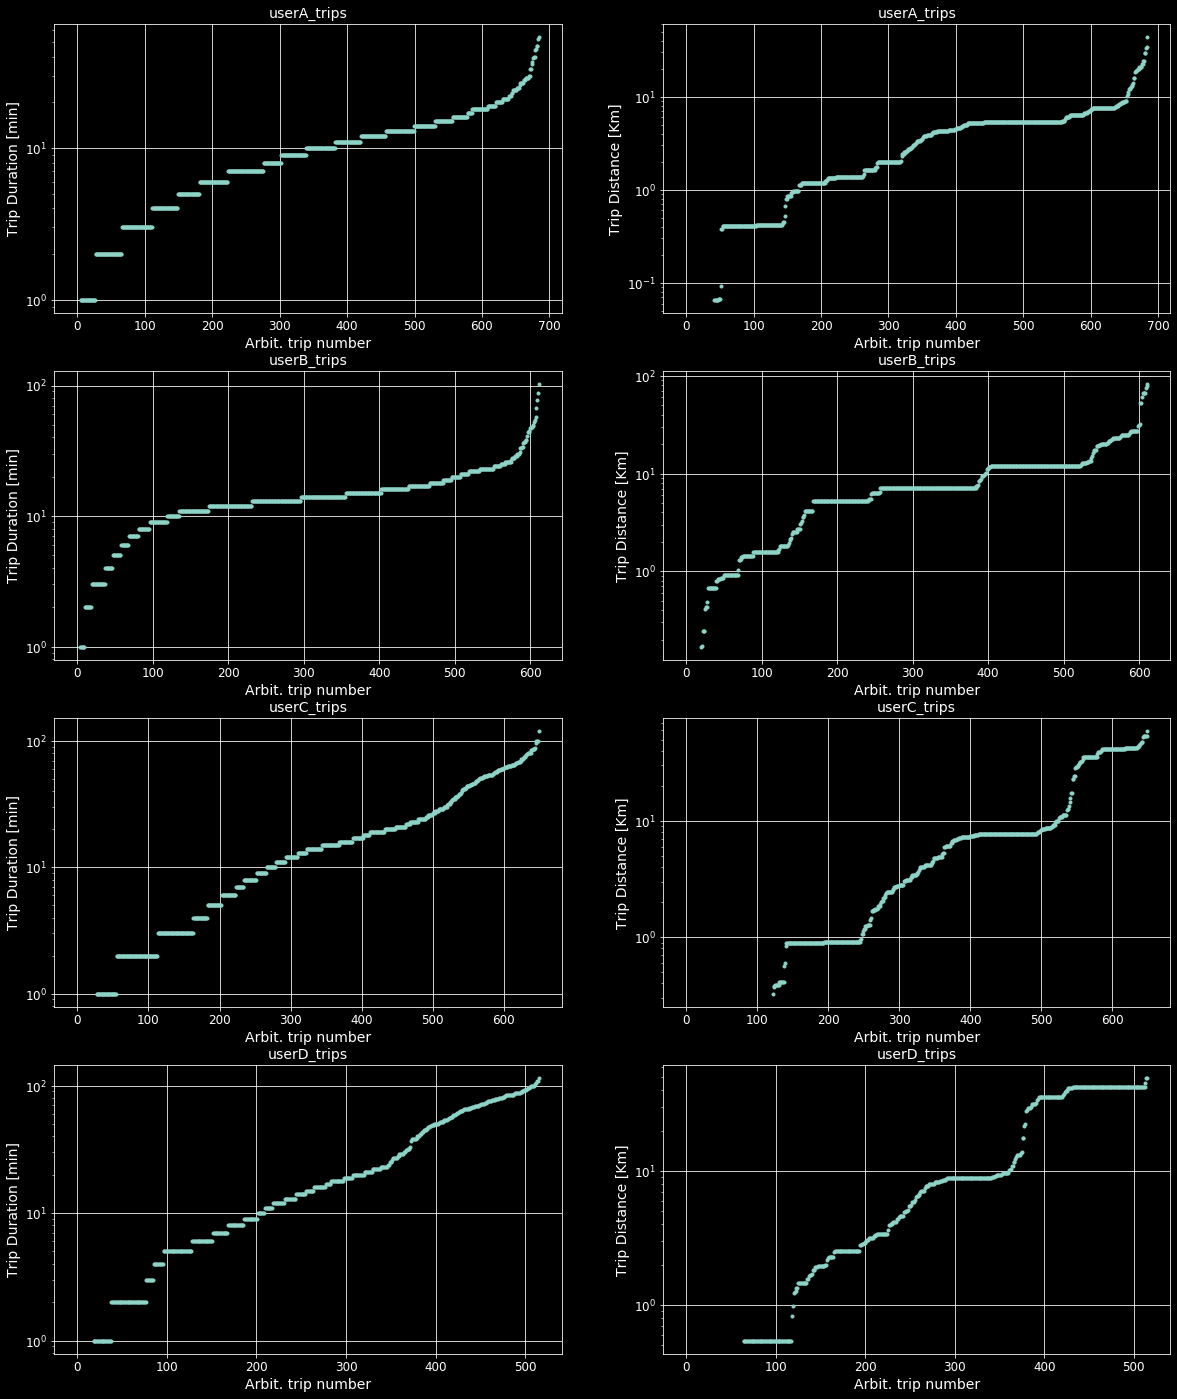

In [0]:
fig = plt.figure(figsize=(20,50))
n_plts = 2*len(userFiles)
n_cols = 2
n_rows = n_plts

j=0
for i in range(n_plts):
    if i%2 == 0:
        fig.add_subplot(n_rows, n_cols, i+1 )
        plt.semilogy(np.linspace(0, len(userTrips[userFiles[j]]['tripDur_min']),len(userTrips[userFiles[j]]['tripDur_min'])), userTrips[userFiles[j]]['tripDur_min'].sort_values(), '.')
        plt.ylabel('Trip Duration [min]', fontsize=14)
    # ----------------------------------
    if i%2 != 0:    
        fig.add_subplot(n_rows, n_cols, i+1 )
        plt.semilogy(np.linspace(0, len(userTrips[userFiles[j]]['tripDis_Km']),len(userTrips[userFiles[j]]['tripDis_Km'])), userTrips[userFiles[j]]['tripDis_Km'].sort_values(), '.')
        plt.ylabel('Trip Distance [Km]', fontsize=14)
    # ----------------------------------    
    plt.xlabel('Arbit. trip number', fontsize=14)
    plt.title(userFiles[j], fontsize=14)
    plt.tick_params(labelsize=12)
    plt.grid()  
    # ----------------------------------    
    if i%2!=0  and i!=0:
        j+=1    


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing
    - Stage 1 save the processed dataset
      - For convenience and book keeping   

# Stage 1 save

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = dataset_to_user_dict(dataset, userFiles)   
lastMonth = getLastMonth(userFiles, userTrips)        
dropList = ['id','start_timezone', 'end_timezone']; userTrips = drop_cols(userFiles, userTrips, dropList) 
userTrips = addGeohash(userFiles, userTrips, precision= 6) # Maximum error: prc = {5: '2.4 Km' , 6: '0.61 Km' ,7 : '0.076 Km', 8 : '0.019 Km'}
userTrips = unifyLatLon(userFiles,userTrips)
userTrips = addTripDur(userFiles, userTrips)          
userTrips = addTripDis(userFiles, userTrips)    
# ======================================================== Old/New
save_proc_dataset(userTrips, name='userTrips', stage=1)       

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  

# Stage 1 load 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance-&-duration as a feature to the current trip 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
# ======================================================== Old/New
userTrips = addLastTripDisDir(userFiles, userTrips)
show = [display('-'*100, key, val.sort_values(by='tripDis_Km').head(1)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min
181,2019-02-08 07:27:39,2019-02-08 07:31:33,37.353302,-121.95739,"1722 Hillebrant Place, Santa Clara CA 95050",37.353302,-121.95739,"1722 Hillebrant Place, Santa Clara CA 95050",9q9k2z,9q9k2z,3,0.0,1.367188,6


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min
590,2019-05-27 11:29:07,2019-05-27 11:32:37,37.024944,-121.564484,"8620 San Ysidro Ave, Gilroy CA 95020",37.024944,-121.564484,"8435 San Ysidro Avenue, Gilroy CA 95020",9q9d9s,9q9d9s,3,0.0,32.0625,26


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min
324,2019-03-26 13:13:52,2019-03-26 13:14:53,37.7743,-121.922737,"11060 Bollinger Canyon Rd, Danville CA 94506",37.7743,-121.922737,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qcs,9q9qcs,1,0.0,0.890137,2


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min
68,2019-02-09 20:38:39,2019-02-09 20:46:50,37.771641,-121.946747,"350 Bollinger Canyon Ln, San Ramon CA 94582",37.771641,-121.946747,"500 Bollinger Canyon Way, San Ramon CA 94582",9q9qch,9q9qch,8,0.0,2.523438,5


# Inspection: prev End-geohash != curr Start-geohash
    - Not all trips start from where the previous trip ended 

In [0]:
end_start_mismatch_idx = {}
for user in userFiles:
    df = userTrips[user]
    lst = (df['end_location_geohash'][:-1].reset_index(drop=True) != df['start_location_geohash'][1:].reset_index(drop=True))
    end_start_mismatch_idx[user] = np.array([i for i in range(len(lst)) if lst[i]==True])
    print(user, '# of trips: ', len(df))
    print(user, '# of trip starts not equal to prev end: ', len(end_start_mismatch_idx[user]))
    print('--'*10)

userA_trips # of trips:  684
userA_trips # of trip starts not equal to prev end:  31
--------------------
userB_trips # of trips:  611
userB_trips # of trip starts not equal to prev end:  5
--------------------
userC_trips # of trips:  649
userC_trips # of trip starts not equal to prev end:  12
--------------------
userD_trips # of trips:  515
userD_trips # of trip starts not equal to prev end:  9
--------------------


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance from current trip start-location to the last trip end-location 
        - Not all trips start from the same location as the last trip end-location 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
# ======================================================== Old/New
userTrips = addEndToStartDis(userFiles, userTrips)
show = [display('-'*100, key, val.head(2)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-01 00:54:00,2019-01-01 01:08:05,37.398380,-121.976433,"4655 Great America Pkwy, Santa Clara CA 95054",37.373932,-122.054558,"610 Grape Ave, Sunnyvale CA 94086",9q9kb2,9q9hwe,14,7.417969,0.000000,0,0.000
1,2019-01-01 01:27:35,2019-01-01 01:42:29,37.373936,-122.054543,"610 Grape Ave, Sunnyvale CA 94086",37.414280,-121.938164,"Zanker Road, San Jose CA 95134",9q9hwe,9q9kc5,14,11.218750,7.417969,14,0.001


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-01 11:31:57,2019-01-01 12:06:19,37.249866,-121.790337,"94 Limewell Ct, San Jose CA 95138",37.234386,-122.062302,"Gaetti Road, Saratoga CA 95070",9q97ut,9q95y6,34,24.140625,0.000000,0,0.000
1,2019-01-01 12:08:31,2019-01-01 12:10:49,37.234375,-122.062294,"Gaetti Road, Saratoga CA 95070",37.234375,-122.062294,"Exit, Saratoga CA 95070",9q95y6,9q95y6,2,0.000000,24.140625,34,0.001


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-03 09:21:08,2019-01-03 09:24:39,37.767647,-121.917366,"1078 S Wedgewood Rd, San Ramon CA 94582",37.774410,-121.922783,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qce,9q9qcs,3,0.890137,0.000000,0,0.000
1,2019-01-03 09:27:46,2019-01-03 10:13:31,37.774300,-121.922737,"11000 Bollinger Canyon Road, Danville CA 94582",37.398548,-121.976440,"4555 Great America Pkwy, Santa Clara CA 95054",9q9qcs,9q9kb2,45,42.062500,0.890137,3,0.013


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-22 08:28:39,2019-01-22 08:47:41,37.765411,-121.893539,"12995 Harcourt Way, San Ramon CA 94582",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qf4,9q9qd8,19,6.664062,0.000000,0,0.000
1,2019-01-22 20:18:28,2019-01-22 20:31:36,37.707661,-121.873268,"4500 Tassajara Rd, Pleasanton CA 94588",37.748581,-121.947823,"9920 Broadmoor Dr, San Ramon CA 94583",9q9qd8,9q9q9p,13,7.980469,6.664062,19,0.003


# Inspection: check the datatypes

In [0]:
userTrips[userFiles[0]].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 15 columns):
start_time                684 non-null datetime64[ns]
end_time                  684 non-null datetime64[ns]
start_location_lat        684 non-null float32
start_location_lon        684 non-null float32
start_location_name       684 non-null object
end_location_lat          684 non-null float32
end_location_lon          684 non-null float32
end_location_name         684 non-null object
start_location_geohash    684 non-null object
end_location_geohash      684 non-null object
tripDur_min               684 non-null uint16
tripDis_Km                684 non-null float16
lastTripDis_Km            684 non-null float16
lastTripDur_min           684 non-null uint16
endToStartDis_Km          684 non-null float16
dtypes: datetime64[ns](2), float16(3), float32(4), object(4), uint16(2)
memory usage: 49.6+ KB


# Inspection : end_location_geohash != start_location_geohash : % below a threshold 
    - For most cases where the end of the last trip is not the same as the start of the current trip, these two mismatched locations are in close proximity
    - This can be used to set the threshold for the next step's denoising 

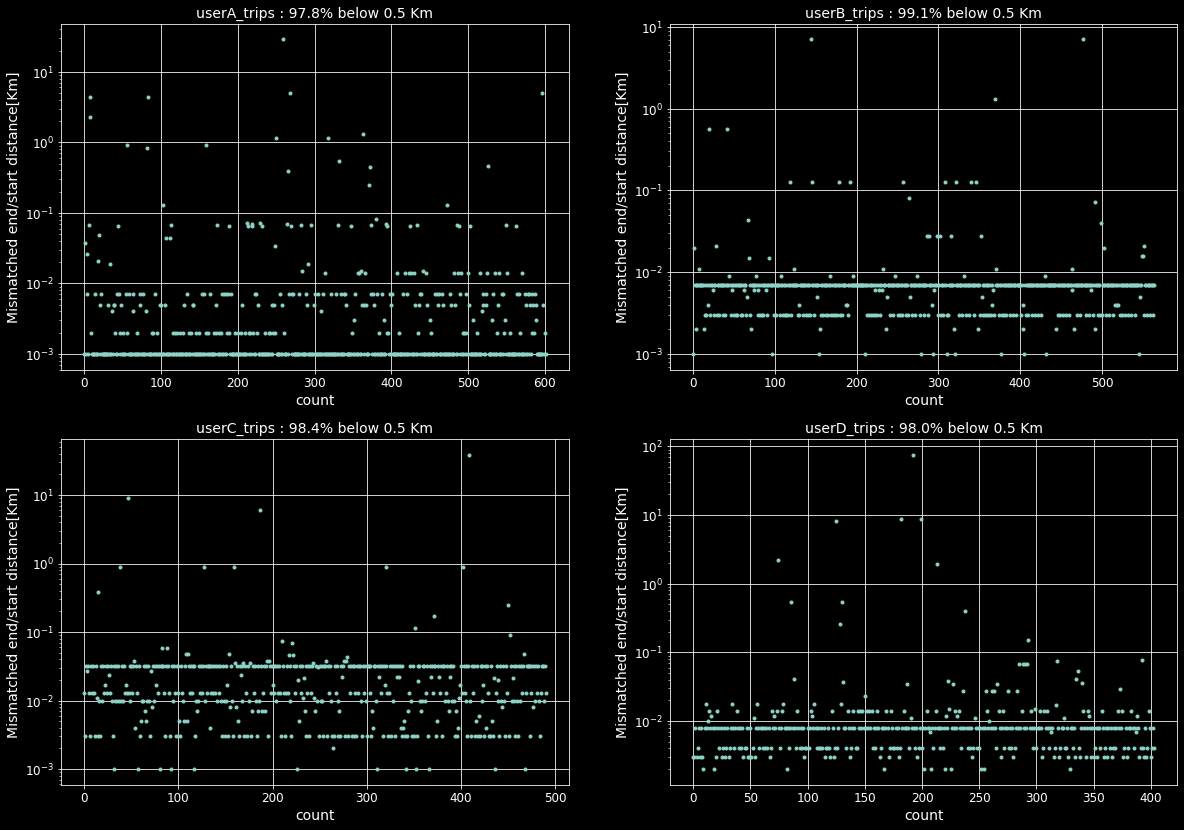

In [0]:
th = 0.5
fig = plt.figure(figsize=(20,14))
n_plts = len(userFiles)
n_cols = np.ceil(n_plts/2)
n_rows = np.ceil(n_plts/2)

for i in range(len(userFiles)):    
    user = userFiles[i]
    total_mismatch   = userTrips[user][userTrips[user]['endToStartDis_Km'] != 0].reset_index(drop=True)
    below_mismatch   = total_mismatch[total_mismatch['endToStartDis_Km'] < th].reset_index(drop=True)
    
    ratio = len(below_mismatch) / len(total_mismatch) * 100
    
    fig.add_subplot(n_rows, n_cols, i+1 )
    plt.semilogy(total_mismatch['endToStartDis_Km'],'.')
    plt.xlabel('count', fontsize=14)
    plt.ylabel('Mismatched end/start distance[Km]', fontsize=14)
    plt.title(f'{userFiles[i]} : {round(ratio,1)}% below {th} Km'  , fontsize=14)
    plt.tick_params(labelsize=12)
    plt.grid()  


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)  # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
# ======================================================== Old/New
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance = th)  # See the previous step's inspection for reasoaning behindminDistance= 0.1 
show = [display('-'*100, key, val.head(2)) for key,val in userTrips.items()]

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-01 00:54:00,2019-01-01 01:08:05,37.398380,-121.976433,"4655 Great America Pkwy, Santa Clara CA 95054",37.373932,-122.054558,"610 Grape Ave, Sunnyvale CA 94086",9q9kb2,9q9hwe,14,7.417969,0.000000,0,0.0
1,2019-01-01 01:27:35,2019-01-01 01:42:29,37.373936,-122.054543,"610 Grape Ave, Sunnyvale CA 94086",37.414280,-121.938164,"Zanker Road, San Jose CA 95134",9q9hwe,9q9kc5,14,11.218750,7.417969,14,0.0


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-01 11:31:57,2019-01-01 12:06:19,37.249866,-121.790337,"94 Limewell Ct, San Jose CA 95138",37.234386,-122.062302,"Gaetti Road, Saratoga CA 95070",9q97ut,9q95y6,34,24.140625,0.000000,0,0.0
1,2019-01-01 12:08:31,2019-01-01 12:10:49,37.234375,-122.062294,"Gaetti Road, Saratoga CA 95070",37.234375,-122.062294,"Exit, Saratoga CA 95070",9q95y6,9q95y6,2,0.000000,24.140625,34,0.0


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-03 09:21:08,2019-01-03 09:24:39,37.767647,-121.917366,"1078 S Wedgewood Rd, San Ramon CA 94582",37.774410,-121.922783,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qce,9q9qcs,3,0.890137,0.000000,0,0.0
1,2019-01-03 09:27:46,2019-01-03 10:13:31,37.774300,-121.922737,"11000 Bollinger Canyon Road, Danville CA 94582",37.398548,-121.976440,"4555 Great America Pkwy, Santa Clara CA 95054",9q9qcs,9q9kb2,45,42.062500,0.890137,3,0.0


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km
0,2019-01-22 08:28:39,2019-01-22 08:47:41,37.765411,-121.893539,"12995 Harcourt Way, San Ramon CA 94582",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qf4,9q9qd8,19,6.664062,0.000000,0,0.0
1,2019-01-22 20:18:28,2019-01-22 20:31:36,37.707661,-121.873268,"4500 Tassajara Rd, Pleasanton CA 94588",37.748581,-121.947823,"9920 Broadmoor Dr, San Ramon CA 94583",9q9qd8,9q9q9p,13,7.980469,6.664062,19,0.0


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of the last trip to the start of the current trip

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance = th)
# ======================================================== Old/New
userTrips = addEndToStartDur(userFiles, userTrips)
show = [display('-'*100, key, val.sort_values(by='endToStartDur_min', ascending=False).head(2)) for key,val in userTrips.items()]   

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min
306,2019-03-12 20:12:46,2019-03-12 20:22:38,37.394817,-121.977898,"4300 Great America Pkwy, Santa Clara CA 95054",37.353306,-121.957375,"1786 Hillebrant Place, Santa Clara CA 95050",9q9k8r,9q9k2z,9,4.960938,0.420898,3,4.960938,6088
69,2019-01-17 09:34:33,2019-01-17 09:45:49,37.360939,-121.961166,"2265 Monroe Street, Santa Clara CA 95050",37.398369,-121.976433,"4659 Great America Pkwy, Santa Clara CA 95054",9q9k89,9q9kb2,11,4.375000,1.367188,5,0.913086,3654


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min
317,2019-03-19 10:09:37,2019-03-19 10:33:07,37.249866,-121.790337,"5717 Sagewell Way, San Jose CA 95138",37.240120,-121.800972,"Cottle Road, San Jose CA 95119",9q97ut,9q97u7,23,1.435547,0.924805,5,0.0,3810
10,2019-01-05 11:17:42,2019-01-05 11:34:37,37.249866,-121.790337,"89 Limewell Court, San Jose CA 95138",37.249474,-121.861977,"5814 Hillview Ave, San Jose CA 95123",9q97ut,9q97fv,16,6.343750,1.566406,13,0.0,2778


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min
187,2019-03-01 08:18:38,2019-03-01 08:38:45,37.77430,-121.922737,"Bollinger Canyon Road, San Ramon CA 94582",37.707718,-121.873024,"The Shops, Pleasanton CA 94588",9q9qcs,9q9qd8,20,8.601562,0.0,35,0.87793,14377
82,2019-01-31 20:15:32,2019-01-31 20:30:44,37.69136,-121.878380,"3120 Santa Rita Rd, Pleasanton CA 94588",37.774410,-121.922783,"N Wedgewood Rd, Danville CA 94506",9q9q6t,9q9qcs,15,10.023438,0.0,20,0.00000,10023


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min
504,2019-05-28 08:26:12,2019-05-28 08:45:59,37.77866,-121.919395,"North Monarch Road, San Ramon CA 94582",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qct,9q9qd8,19,8.875,8.875,17,0.0,5016
459,2019-05-13 08:33:34,2019-05-13 08:53:46,37.77866,-121.919395,"North Monarch Road, San Ramon CA 94582",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qct,9q9qd8,20,8.875,0.000,17,0.0,4331


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of the last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance=th)
userTrips = addEndToStartDur(userFiles, userTrips)
# ======================================================== Old/New
userTrips = addSameDay(userFiles, userTrips)
show = [display('-'*100, key,val[10:16]) for key,val in userTrips.items()]   

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay
10,2019-01-04 08:42:53,2019-01-04 08:54:08,37.380199,-121.964561,"San Tomas Expressway, Santa Clara CA 95054",37.389309,-121.983490,"3127 Mission College Blvd, Santa Clara CA 95054",9q9k8s,9q9k8n,11,1.956055,4.375000,13,2.275391,1415,0
11,2019-01-04 09:33:54,2019-01-04 09:40:46,37.389294,-121.983505,"3127 Mission College Blvd, Santa Clara CA 95054",37.398369,-121.976433,"4659 Great America Pkwy, Santa Clara CA 95054",9q9k8n,9q9kb2,6,1.186523,1.956055,11,0.000000,39,1
12,2019-01-04 12:30:39,2019-01-04 12:44:47,37.398380,-121.976433,"4659 Great America Pkwy, Santa Clara CA 95054",37.353306,-121.957375,"1745 El Camino Real, Santa Clara CA 95050",9q9kb2,9q9k2z,14,5.285156,1.186523,6,0.000000,169,1
13,2019-01-04 14:30:02,2019-01-04 14:41:00,37.353302,-121.957390,"1745 El Camino Real, Santa Clara CA 95050",37.398369,-121.976433,"4655 Great America Pkwy, Santa Clara CA 95054",9q9k2z,9q9kb2,10,5.285156,5.285156,14,0.000000,105,1
14,2019-01-04 18:15:00,2019-01-04 18:29:30,37.398380,-121.976433,"4655 Great America Pkwy, Santa Clara CA 95054",37.353306,-121.957375,"1722 Hillebrant Place, Santa Clara CA 95050",9q9kb2,9q9k2z,14,5.285156,5.285156,10,0.000000,214,1
15,2019-01-05 11:37:54,2019-01-05 11:41:13,37.353302,-121.957390,"1722 Hillebrant Place, Santa Clara CA 95050",37.352139,-121.961830,"1894 Clay Street, Santa Clara CA 95050",9q9k2z,9q9k2x,3,0.413086,5.285156,14,0.000000,1028,0


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay
10,2019-01-05 11:17:42,2019-01-05 11:34:37,37.249866,-121.790337,"89 Limewell Court, San Jose CA 95138",37.249474,-121.861977,"5814 Hillview Ave, San Jose CA 95123",9q97ut,9q97fv,16,6.343750,1.566406,13,0.0,2778,0
11,2019-01-05 12:15:03,2019-01-05 12:30:19,37.249413,-121.861885,"5814 Hillview Ave, San Jose CA 95123",37.249817,-121.790382,"5724 Sagewell Way, San Jose CA 95138",9q97fv,9q97ut,15,6.328125,6.343750,16,0.0,40,1
12,2019-01-05 12:56:34,2019-01-05 13:08:17,37.249866,-121.790337,"94 Limewell Ct, San Jose CA 95138",37.238018,-121.800133,"290 International Cir, San Jose CA 95119",9q97ut,9q97u6,11,1.577148,6.328125,15,0.0,26,1
13,2019-01-05 16:41:16,2019-01-05 16:53:20,37.238026,-121.800056,"290 International Cir, San Jose CA 95119",37.249817,-121.790382,"89 Limewell Court, San Jose CA 95138",9q97u6,9q97ut,12,1.566406,1.577148,11,0.0,212,1
14,2019-01-06 07:37:45,2019-01-06 07:58:37,37.249866,-121.790337,"89 Limewell Court, San Jose CA 95138",37.387211,-122.009560,"915 De Guigne Dr, Sunnyvale CA 94085",9q97ut,9q9hxw,20,24.671875,1.566406,12,0.0,884,0
15,2019-01-06 16:32:29,2019-01-06 17:02:44,37.387218,-122.009644,"915 De Guigne Dr, Sunnyvale CA 94085",37.249817,-121.790382,"94 Limewell Ct, San Jose CA 95138",9q9hxw,9q97ut,30,24.687500,24.671875,20,0.0,513,1


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay
10,2019-01-07 21:24:05,2019-01-07 21:26:26,37.774300,-121.922737,"N Wedgewood Rd, Danville CA 94506",37.767521,-121.917038,"1017 S Wedgewood Rd, Danville CA 94506",9q9qcs,9q9qce,2,0.905762,0.890137,17,0.0,4,1
11,2019-01-08 08:20:37,2019-01-08 08:55:38,37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",9q9qce,9q9qce,35,0.000000,0.905762,2,0.0,654,0
12,2019-01-08 12:30:37,2019-01-08 12:33:47,37.767647,-121.917366,"1017 S Wedgewood Rd, Danville CA 94506",37.774410,-121.922783,"11000 Bollinger Canyon Road, San Ramon CA 94582",9q9qce,9q9qcs,3,0.890137,0.000000,35,0.0,214,1
13,2019-01-08 12:42:39,2019-01-08 13:24:36,37.774300,-121.922737,"11000 Bollinger Canyon Road, San Ramon CA 94582",37.398548,-121.976440,"4655 Great America Pkwy, Santa Clara CA 95054",9q9qcs,9q9kb2,41,42.062500,0.890137,3,0.0,8,1
14,2019-01-08 19:29:19,2019-01-08 20:32:55,37.398544,-121.976479,"4655 Great America Pkwy, Santa Clara CA 95054",37.767521,-121.917038,"1017 S Wedgewood Rd, Danville CA 94506",9q9kb2,9q9qce,63,41.375000,42.062500,41,0.0,364,1
15,2019-01-09 08:25:50,2019-01-09 09:00:13,37.767647,-121.917366,"3599 Cinnamon Ridge Rd, San Ramon CA 94582",37.658974,-121.876801,"301 Main Street, Pleasanton CA 94566",9q9qce,9q9q4x,34,12.601562,41.375000,63,0.0,712,0


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay
10,2019-01-25 08:44:44,2019-01-25 09:02:39,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.707672,-121.873299,"The Shops, Pleasanton CA 94588",9q9qct,9q9qd8,17,8.875000,8.875000,15,0.0,731,0
11,2019-01-25 20:13:41,2019-01-25 20:21:23,37.707661,-121.873268,"The Shops, Pleasanton CA 94588",37.703934,-121.910866,"Village Dr, Dublin CA 94568",9q9qd8,9q9q3z,7,3.332031,8.875000,17,0.0,671,1
12,2019-01-25 20:29:40,2019-01-25 20:43:59,37.703945,-121.910889,"Village Dr, Dublin CA 94568",37.778702,-121.919327,"1714 Campanula Dr, Danville CA 94506",9q9q3z,9q9qct,14,8.343750,3.332031,7,0.0,8,1
13,2019-01-26 08:41:34,2019-01-26 08:50:27,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.769642,-121.956116,"12601 Alcosta Blvd, San Ramon CA 94583",9q9qct,9q9qbg,8,3.380859,8.343750,14,0.0,717,0
14,2019-01-26 10:11:34,2019-01-26 10:20:05,37.769497,-121.956017,"12601 Alcosta Blvd, San Ramon CA 94583",37.778702,-121.919327,"1714 Campanula Dr, Danville CA 94506",9q9qbg,9q9qct,8,3.382812,3.380859,8,0.0,81,1
15,2019-01-26 14:39:36,2019-01-26 14:43:51,37.778660,-121.919395,"1714 Campanula Dr, Danville CA 94506",37.781303,-121.941284,"4417 Lilac Ridge Rd, San Ramon CA 94582",9q9qct,9q9qcj,4,1.946289,3.382812,8,0.0,259,1


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohash ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 

In [0]:
th= 0.5

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance=th)
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addSameDay(userFiles, userTrips)
# ================================================================================ Old/New
userTrips = addStartGeoRank(userFiles, userTrips)
userTrips = addEndGeoRank(userFiles, userTrips)
show = [display('-'*100, key,val.tail(2)) for key,val in userTrips.items()]     

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,end_location_freq
682,2019-05-30 15:45:58,2019-05-30 15:53:56,37.389294,-121.983505,"3127 Mission College Blvd, Santa Clara CA 95054",37.398369,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",9q9k8n,9q9kb2,7,1.186523,1.185547,5,0.0,7,1,20,106
683,2019-05-30 18:32:06,2019-05-30 19:02:10,37.398380,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",37.353306,-121.957375,"1786 Hillebrant Place, Santa Clara CA 95050",9q9kb2,9q9k2z,30,5.285156,1.186523,7,0.0,158,1,102,152


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,end_location_freq
609,2019-05-30 12:02:21,2019-05-30 12:15:30,37.235863,-121.846962,"751 Sunset Glen Drive, San Jose CA 95123",37.246136,-121.925385,"1923 Laurinda Drive, San Jose CA 95124",9q97g6,9q97cs,13,7.035156,7.035156,11,0.0,8,1,92,95
610,2019-05-30 18:49:46,2019-05-30 19:06:20,37.246189,-121.925346,"1931 Laurinda Drive, San Jose CA 95124",37.249817,-121.790382,"89 Limewell Court, San Jose CA 95138",9q97cs,9q97ut,16,11.953125,7.035156,13,0.0,394,1,94,154


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,end_location_freq
647,2019-05-30 20:58:15,2019-05-30 20:59:21,37.7743,-121.922737,"11050 Bollinger Canyon Road, San Ramon CA 94582",37.774300,-121.922737,"Dougherty Rd, Danville CA 94506",9q9qcs,9q9qcs,1,0.000000,0.890137,2,0.0,9,1,69,65
648,2019-05-30 21:05:26,2019-05-30 21:08:11,37.7743,-121.922737,"Dougherty Rd, Danville CA 94506",37.767521,-121.917038,"1017 S Wedgewood Rd, Danville CA 94506",9q9qcs,9q9qce,2,0.905762,0.000000,1,0.0,6,1,69,199


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,tripDur_min,tripDis_Km,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,end_location_freq
513,2019-05-30 09:06:09,2019-05-30 09:55:31,37.727547,-121.870483,"6363 Tassajara Rd, Livermore CA 94551",37.398636,-121.976479,"4655 Great America Pkwy, Santa Clara CA 95054",9q9qdu,9q9kb2,49,37.7500,7.128906,26,0.0,25,1,2,54
514,2019-05-30 19:16:43,2019-05-30 20:25:58,37.398624,-121.976524,"4655 Great America Pkwy, Santa Clara CA 95054",37.778702,-121.919327,"1714 Campanula Dr, Danville CA 94506",9q9kb2,9q9qct,69,42.5625,37.750000,49,0.0,561,1,52,168


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
th= 0.5
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance=th)
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addSameDay(userFiles, userTrips)
userTrips = addStartGeoRank(userFiles, userTrips)
userTrips = addEndGeoRank(userFiles, userTrips)
# ================================================================================ Old/New
userTrips = addDisToTopStartGeos(userFiles, userTrips, n_most_freq = 10)
userTrips = addDisToTopEndGeos(userFiles, userTrips, n_most_freq = 10)
show = [display('-'*100, key,val.tail(2)) for key,val in userTrips.items()]     

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,dis_to_end_geo_1_Km,dis_to_end_geo_2_Km,dis_to_end_geo_3_Km,dis_to_end_geo_4_Km,dis_to_end_geo_5_Km,dis_to_end_geo_6_Km,dis_to_end_geo_7_Km,dis_to_end_geo_8_Km,dis_to_end_geo_9_Km,dis_to_end_geo_10_Km
682,2019-05-30 15:45:58,2019-05-30 15:53:56,37.389294,-121.983505,"3127 Mission College Blvd, Santa Clara CA 95054",37.398369,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",9q9k8n,9q9kb2,...,4.621094,1.186523,4.554688,4.550781,5.445312,4.113281,0.002001,7.613281,4.582031,3.783203
683,2019-05-30 18:32:06,2019-05-30 19:02:10,37.398380,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",37.353306,-121.957375,"1786 Hillebrant Place, Santa Clara CA 95050",9q9kb2,9q9k2z,...,5.285156,0.001000,5.300781,5.222656,6.390625,5.023438,1.185547,8.781250,5.765625,4.433594


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,dis_to_end_geo_1_Km,dis_to_end_geo_2_Km,dis_to_end_geo_3_Km,dis_to_end_geo_4_Km,dis_to_end_geo_5_Km,dis_to_end_geo_6_Km,dis_to_end_geo_7_Km,dis_to_end_geo_8_Km,dis_to_end_geo_9_Km,dis_to_end_geo_10_Km
609,2019-05-30 12:02:21,2019-05-30 12:15:30,37.235863,-121.846962,"751 Sunset Glen Drive, San Jose CA 95123",37.246136,-121.925385,"1923 Laurinda Drive, San Jose CA 95124",9q97g6,9q97cs,...,5.242188,7.035156,0.003000,4.152344,5.421875,4.097656,5.851562,24.671875,6.433594,4.777344
610,2019-05-30 18:49:46,2019-05-30 19:06:20,37.246189,-121.925346,"1931 Laurinda Drive, San Jose CA 95124",37.249817,-121.790382,"89 Limewell Court, San Jose CA 95138",9q97cs,9q97ut,...,11.953125,0.007000,7.035156,11.125000,12.273438,11.031250,12.679688,19.828125,13.382812,11.257812


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,dis_to_end_geo_1_Km,dis_to_end_geo_2_Km,dis_to_end_geo_3_Km,dis_to_end_geo_4_Km,dis_to_end_geo_5_Km,dis_to_end_geo_6_Km,dis_to_end_geo_7_Km,dis_to_end_geo_8_Km,dis_to_end_geo_9_Km,dis_to_end_geo_10_Km
647,2019-05-30 20:58:15,2019-05-30 20:59:21,37.7743,-121.922737,"11050 Bollinger Canyon Road, San Ramon CA 94582",37.774300,-121.922737,"Dougherty Rd, Danville CA 94506",9q9qcs,9q9qcs,...,0.905762,0.013,8.601562,42.0625,10.015625,8.5,12.101562,1.248047,2.804688,4.160156
648,2019-05-30 21:05:26,2019-05-30 21:08:11,37.7743,-121.922737,"Dougherty Rd, Danville CA 94506",37.767521,-121.917038,"1017 S Wedgewood Rd, Danville CA 94506",9q9qcs,9q9qce,...,0.905762,0.013,8.601562,42.0625,10.015625,8.5,12.101562,1.248047,2.804688,4.160156


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,dis_to_end_geo_1_Km,dis_to_end_geo_2_Km,dis_to_end_geo_3_Km,dis_to_end_geo_4_Km,dis_to_end_geo_5_Km,dis_to_end_geo_6_Km,dis_to_end_geo_7_Km,dis_to_end_geo_8_Km,dis_to_end_geo_9_Km,dis_to_end_geo_10_Km
513,2019-05-30 09:06:09,2019-05-30 09:55:31,37.727547,-121.870483,"6363 Tassajara Rd, Livermore CA 94551",37.398636,-121.976479,"4655 Great America Pkwy, Santa Clara CA 95054",9q9qdu,9q9kb2,...,7.128906,37.750000,6.933594,2.224609,8.304688,4.417969,5.710938,3.025391,8.867188,2.955078
514,2019-05-30 19:16:43,2019-05-30 20:25:58,37.398624,-121.976524,"4655 Great America Pkwy, Santa Clara CA 95054",37.778702,-121.919327,"1714 Campanula Dr, Danville CA 94506",9q9kb2,9q9qct,...,42.562500,0.004002,42.062500,35.562500,41.562500,34.437500,41.343750,34.750000,41.281250,34.843750


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 
    - Add datetime features 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance=th)
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addSameDay(userFiles, userTrips)
userTrips = addStartGeoRank(userFiles, userTrips)
userTrips = addEndGeoRank(userFiles, userTrips)
userTrips = addDisToTopStartGeos(userFiles, userTrips, n_most_freq = 10)
userTrips = addDisToTopEndGeos(userFiles, userTrips, n_most_freq = 10)
# ================================================================================ Old/New
userTrips = addDatetimeFeatures(userFiles, userTrips)
show = [display('-'*100, key,val.tail(2)) for key,val in userTrips.items()]     

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,hour_of_day,night,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year
682,2019-05-30 15:45:58,2019-05-30 15:53:56,37.389294,-121.983505,"3127 Mission College Blvd, Santa Clara CA 95054",37.398369,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",9q9k8n,9q9kb2,...,15,0,0,1,0,3,0,0,30,5
683,2019-05-30 18:32:06,2019-05-30 19:02:10,37.398380,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",37.353306,-121.957375,"1786 Hillebrant Place, Santa Clara CA 95050",9q9kb2,9q9k2z,...,18,0,0,0,1,3,0,0,30,5


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,hour_of_day,night,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year
609,2019-05-30 12:02:21,2019-05-30 12:15:30,37.235863,-121.846962,"751 Sunset Glen Drive, San Jose CA 95123",37.246136,-121.925385,"1923 Laurinda Drive, San Jose CA 95124",9q97g6,9q97cs,...,12,0,0,1,0,3,0,0,30,5
610,2019-05-30 18:49:46,2019-05-30 19:06:20,37.246189,-121.925346,"1931 Laurinda Drive, San Jose CA 95124",37.249817,-121.790382,"89 Limewell Court, San Jose CA 95138",9q97cs,9q97ut,...,18,0,0,0,1,3,0,0,30,5


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,hour_of_day,night,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year
647,2019-05-30 20:58:15,2019-05-30 20:59:21,37.7743,-121.922737,"11050 Bollinger Canyon Road, San Ramon CA 94582",37.774300,-121.922737,"Dougherty Rd, Danville CA 94506",9q9qcs,9q9qcs,...,20,0,0,0,1,3,0,0,30,5
648,2019-05-30 21:05:26,2019-05-30 21:08:11,37.7743,-121.922737,"Dougherty Rd, Danville CA 94506",37.767521,-121.917038,"1017 S Wedgewood Rd, Danville CA 94506",9q9qcs,9q9qce,...,21,0,0,0,1,3,0,0,30,5


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,hour_of_day,night,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year
513,2019-05-30 09:06:09,2019-05-30 09:55:31,37.727547,-121.870483,"6363 Tassajara Rd, Livermore CA 94551",37.398636,-121.976479,"4655 Great America Pkwy, Santa Clara CA 95054",9q9qdu,9q9kb2,...,9,0,1,0,0,3,0,0,30,5
514,2019-05-30 19:16:43,2019-05-30 20:25:58,37.398624,-121.976524,"4655 Great America Pkwy, Santa Clara CA 95054",37.778702,-121.919327,"1714 Campanula Dr, Danville CA 94506",9q9kb2,9q9qct,...,19,0,0,0,1,3,0,0,30,5


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 
    - Add datetime features 
    - Convert geohashes to classes represented by numbers 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance=th)
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addSameDay(userFiles, userTrips)
userTrips = addStartGeoRank(userFiles, userTrips)
userTrips = addEndGeoRank(userFiles, userTrips)
userTrips = addDisToTopStartGeos(userFiles, userTrips, n_most_freq = 10)
userTrips = addDisToTopEndGeos(userFiles, userTrips, n_most_freq = 10)
userTrips = addDatetimeFeatures(userFiles, userTrips)
# ================================================================================ Old/New
userTrips = addGeohashClasses(userFiles, userTrips)
show = [display('-'*100, key,val.tail(2)) for key,val in userTrips.items()]     

'----------------------------------------------------------------------------------------------------'

'userA_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
682,2019-05-30 15:45:58,2019-05-30 15:53:56,37.389294,-121.983505,"3127 Mission College Blvd, Santa Clara CA 95054",37.398369,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",9q9k8n,9q9kb2,...,0,1,0,3,0,0,30,5,49,55
683,2019-05-30 18:32:06,2019-05-30 19:02:10,37.398380,-121.976433,"4699 Old Ironsides Drive, Santa Clara CA 95054",37.353306,-121.957375,"1786 Hillebrant Place, Santa Clara CA 95050",9q9kb2,9q9k2z,...,0,0,1,3,0,0,30,5,55,38


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
609,2019-05-30 12:02:21,2019-05-30 12:15:30,37.235863,-121.846962,"751 Sunset Glen Drive, San Jose CA 95123",37.246136,-121.925385,"1923 Laurinda Drive, San Jose CA 95124",9q97g6,9q97cs,...,0,1,0,3,0,0,30,5,8,3
610,2019-05-30 18:49:46,2019-05-30 19:06:20,37.246189,-121.925346,"1931 Laurinda Drive, San Jose CA 95124",37.249817,-121.790382,"89 Limewell Court, San Jose CA 95138",9q97cs,9q97ut,...,0,0,1,3,0,0,30,5,3,23


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
647,2019-05-30 20:58:15,2019-05-30 20:59:21,37.7743,-121.922737,"11050 Bollinger Canyon Road, San Ramon CA 94582",37.774300,-121.922737,"Dougherty Rd, Danville CA 94506",9q9qcs,9q9qcs,...,0,0,1,3,0,0,30,5,57,57
648,2019-05-30 21:05:26,2019-05-30 21:08:11,37.7743,-121.922737,"Dougherty Rd, Danville CA 94506",37.767521,-121.917038,"1017 S Wedgewood Rd, Danville CA 94506",9q9qcs,9q9qce,...,0,0,1,3,0,0,30,5,57,55


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,start_time,end_time,start_location_lat,start_location_lon,start_location_name,end_location_lat,end_location_lon,end_location_name,start_location_geohash,end_location_geohash,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
513,2019-05-30 09:06:09,2019-05-30 09:55:31,37.727547,-121.870483,"6363 Tassajara Rd, Livermore CA 94551",37.398636,-121.976479,"4655 Great America Pkwy, Santa Clara CA 95054",9q9qdu,9q9kb2,...,1,0,0,3,0,0,30,5,65,7
514,2019-05-30 19:16:43,2019-05-30 20:25:58,37.398624,-121.976524,"4655 Great America Pkwy, Santa Clara CA 95054",37.778702,-121.919327,"1714 Campanula Dr, Danville CA 94506",9q9kb2,9q9qct,...,0,0,1,3,0,0,30,5,7,59


# Inspect columns
  - This will be used to specify a droplist of columns

In [0]:
userTrips[userFiles[0]].columns.tolist() 

['start_time',
 'end_time',
 'start_location_lat',
 'start_location_lon',
 'start_location_name',
 'end_location_lat',
 'end_location_lon',
 'end_location_name',
 'start_location_geohash',
 'end_location_geohash',
 'tripDur_min',
 'tripDis_Km',
 'lastTripDis_Km',
 'lastTripDur_min',
 'endToStartDis_Km',
 'endToStartDur_min',
 'is_sameDay',
 'start_location_freq',
 'end_location_freq',
 'dis_to_start_geo_1_Km',
 'dis_to_start_geo_2_Km',
 'dis_to_start_geo_3_Km',
 'dis_to_start_geo_4_Km',
 'dis_to_start_geo_5_Km',
 'dis_to_start_geo_6_Km',
 'dis_to_start_geo_7_Km',
 'dis_to_start_geo_8_Km',
 'dis_to_start_geo_9_Km',
 'dis_to_start_geo_10_Km',
 'dis_to_end_geo_1_Km',
 'dis_to_end_geo_2_Km',
 'dis_to_end_geo_3_Km',
 'dis_to_end_geo_4_Km',
 'dis_to_end_geo_5_Km',
 'dis_to_end_geo_6_Km',
 'dis_to_end_geo_7_Km',
 'dis_to_end_geo_8_Km',
 'dis_to_end_geo_9_Km',
 'dis_to_end_geo_10_Km',
 'hour_of_day',
 'night',
 'morning',
 'afternoon',
 'evening',
 'day_of_week',
 'is_weekend',
 'is_holiday',


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 
    - Add datetime features 
    - Convert geohashes to classes represented by numbers 
    - Save stage 2

# Stage 2 save 

In [0]:
dataset, userFiles = access_dataset(Path('dataset/'))
userTrips = load_proc_dataset(name='userTrips', stage=1)   # Stage 1 load 
userTrips = addLastTripDisDir(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
th = 0.5; userTrips = denoiseDis(userFiles, userTrips, cols=['lastTripDis_Km', 'endToStartDis_Km'], minDistance=th)
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addSameDay(userFiles, userTrips)
userTrips = addStartGeoRank(userFiles, userTrips)
userTrips = addEndGeoRank(userFiles, userTrips)
userTrips = addDisToTopStartGeos(userFiles, userTrips, n_most_freq = 10)
userTrips = addDisToTopEndGeos(userFiles, userTrips, n_most_freq = 10)
userTrips = addDatetimeFeatures(userFiles, userTrips)
userTrips = addGeohashClasses(userFiles, userTrips)
# ================================================================================ Old/New
save_proc_dataset(userTrips, name='userTrips' , stage=2)    # Stage 2 save 
#show = [display('-'*100, key,val.head(1)) for key,val in userTrips.items()]     

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 
    - Add datetime features 
    - Convert geohashes to classes represented by numbers 
    - Save stage 2
    - Load stage 2
    - Drop columns 

In [0]:
# ================================================================================ Old/New
load_proc_dataset(name='userTrips' , stage=2)    # Stage 2 load
# ----------
dropList = ['id', 'start_time', 'end_time', 'start_location_lat',
 'start_location_lon',
 'start_location_name',
 'end_location_lat',
 'end_location_lon',
 'end_location_name',
 'start_location_geohash',
 'end_location_geohash', 'tripDur_min',
 'tripDis_Km','end_location_freq']
userTrips = drop_cols(userFiles, userTrips, dropList)

# Inspect columns
  - This will be used to specify a droplist of columns

In [0]:
userTrips[userFiles[0]].columns.tolist() 

['lastTripDis_Km',
 'lastTripDur_min',
 'endToStartDis_Km',
 'endToStartDur_min',
 'is_sameDay',
 'start_location_freq',
 'dis_to_start_geo_1_Km',
 'dis_to_start_geo_2_Km',
 'dis_to_start_geo_3_Km',
 'dis_to_start_geo_4_Km',
 'dis_to_start_geo_5_Km',
 'dis_to_start_geo_6_Km',
 'dis_to_start_geo_7_Km',
 'dis_to_start_geo_8_Km',
 'dis_to_start_geo_9_Km',
 'dis_to_start_geo_10_Km',
 'dis_to_end_geo_1_Km',
 'dis_to_end_geo_2_Km',
 'dis_to_end_geo_3_Km',
 'dis_to_end_geo_4_Km',
 'dis_to_end_geo_5_Km',
 'dis_to_end_geo_6_Km',
 'dis_to_end_geo_7_Km',
 'dis_to_end_geo_8_Km',
 'dis_to_end_geo_9_Km',
 'dis_to_end_geo_10_Km',
 'hour_of_day',
 'night',
 'morning',
 'afternoon',
 'evening',
 'day_of_week',
 'is_weekend',
 'is_holiday',
 'day_of_month',
 'month_of_year',
 'start_class',
 'end_class']

# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 
    - Add datetime features 
    - Convert geohashes to classes represented by numbers 
    - Save stage 2
    - Load stage 2
    - Drop columns 
    - Train/Val split
        - Train on first 4 month : from Jan/2019 through April/2019
        - Validate on the last month:  May/2019

In [0]:
load_proc_dataset(name='userTrips' , stage=2)    # Stage 2 load
# ----------
dropList = ['id', 'start_time', 'end_time', 'start_location_lat', 'start_location_lon', 'start_location_name', 'end_location_lat','end_location_lon', 'end_location_name', 'start_location_geohash', 'end_location_geohash', 'tripDur_min','tripDis_Km']
userTrips = drop_cols(userFiles, userTrips, dropList)
# ----------
# ================================================================================ Old/New
userTrains, userValids = train_val_split(userFiles, userTrips, lastmonth= 5)
print('Training Set', '='*150)
show = [display('-'*100, key,val.tail(1)) for key,val in userTrains.items()]   
print('\n\n Validation Set', '='*150)
show = [display('-'*100, key,val.head(1)) for key,val in userValids.items()]     

Training Set ======================================================================================================================================================


'----------------------------------------------------------------------------------------------------'

'userA_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
542,1.044922,9,0.0,276,1,102,5.265625,0.070984,5.246094,5.226562,...,0,0,1,1,0,0,30,4,55,38


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
484,4.21875,8,0.0,9,1,92,5.285156,6.996094,0.10498,4.199219,...,0,1,0,1,0,0,30,4,8,23


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
532,0.0,0,0.0,4,1,69,0.710938,0.024002,8.601562,42.125,...,1,0,0,4,0,0,26,4,58,56


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
413,3.158203,6,0.0,14,1,2,3.158203,39.78125,2.828125,5.789062,...,0,0,1,1,0,0,30,4,53,59




 Validation Set ======================================================================================================================================================


'----------------------------------------------------------------------------------------------------'

'userA_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
543,5.265625,15,0.0,948,0,143,0.0,5.328125,0.270996,0.072021,...,1,0,0,2,0,0,1,5,38,55


'----------------------------------------------------------------------------------------------------'

'userB_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
485,5.269531,13,0.0,1231,0,153,0.0,11.96875,5.179688,1.566406,...,1,0,0,2,0,0,1,5,23,3


'----------------------------------------------------------------------------------------------------'

'userC_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
533,0.923828,4,0.780762,7462,0,69,0.583984,0.136963,8.46875,42.0625,...,0,1,0,2,0,0,1,5,58,58


'----------------------------------------------------------------------------------------------------'

'userD_trips'

,lastTripDis_Km,lastTripDur_min,endToStartDis_Km,endToStartDur_min,is_sameDay,start_location_freq,dis_to_start_geo_1_Km,dis_to_start_geo_2_Km,dis_to_start_geo_3_Km,dis_to_start_geo_4_Km,...,morning,afternoon,evening,day_of_week,is_weekend,is_holiday,day_of_month,month_of_year,start_class,end_class
414,3.15625,6,0.0,702,0,165,0.0,42.5625,0.544922,8.90625,...,1,0,0,2,0,0,1,5,61,13


# Running pipeline ...
    - Access the dataset and user files 
    - Load the dataset into a dict with user filenames as keys
    - Extract the last recorded month for various users into a list
        - This will be usesd for train/validation split
    - Drop columns in the dataframes based on a user-defined dropList 
        - id is dropped, Pandas has its own index
        - timezones are dropped because start and end timezones are the same for each users
    - Add geohashes based on lat,lon values
    - Add trip duration in min
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Add trip distances in Km
        - Used for diagnostic, analysis, various data processing and feature engineering (last trips)
    - Stage 1 save the processed dataset
      - For convenience and book keeping   
    - Stage 1 load the processed dataset
      - For convenience and book keeping  
    - Add last trip distance and duration as a feature to the current trip 
    - Add distance to the last trip location 
        - Not all trips start from the same location as the last trip end-location 
    - Denoise distances based on user-specified column labels and user-defined min-distance in Km
        - All distances (in user-specified columns) equal-to or lower than the min-distance will be set to zero 
    - Add time passed from the end of last trip to the beginning of the current trip
    - Add whether the current trip is taking place on the same day as the last trip
    - Add geohashe ranks: rank is based on frequency of occurance    
            -  Rank stats are based on Train/Val data split 
            -  We will use the last month for validation and the rest for training 
            -  Assumption here is that we don't have access to certain data for the last month
                - For example, the frquency of geohash occurance is not known for the entire last month when we start predicting on the first day of the last month  
                - But we can assume we will have access to the last trip data for validation during the last month
                - The details of how the dataprocessing would be performed in general is subject to more discussion
                    - Here, we want to make sure to use logically-sound/feasible assumptions for data processing and prediction 
    - For each start_location, add its distance to the top "n" most frequent geohashes as features 
    - Add datetime features 
    - Convert geohashes to classes represented by numbers 
    - Save stage 2
    - Load stage 2
    - Drop columns 
    - Train/Val split
        - Train on first 4 month : from Jan/2019 through April/2019
        - Validate on the the last month:  May/2019

In [0]:
userValids[userFiles[0]].columns.tolist()

['lastTripDis_Km',
 'lastTripDur_min',
 'endToStartDis_Km',
 'endToStartDur_min',
 'is_sameDay',
 'start_location_freq',
 'dis_to_start_geo_1_Km',
 'dis_to_start_geo_2_Km',
 'dis_to_start_geo_3_Km',
 'dis_to_start_geo_4_Km',
 'dis_to_start_geo_5_Km',
 'dis_to_start_geo_6_Km',
 'dis_to_start_geo_7_Km',
 'dis_to_start_geo_8_Km',
 'dis_to_start_geo_9_Km',
 'dis_to_start_geo_10_Km',
 'dis_to_end_geo_1_Km',
 'dis_to_end_geo_2_Km',
 'dis_to_end_geo_3_Km',
 'dis_to_end_geo_4_Km',
 'dis_to_end_geo_5_Km',
 'dis_to_end_geo_6_Km',
 'dis_to_end_geo_7_Km',
 'dis_to_end_geo_8_Km',
 'dis_to_end_geo_9_Km',
 'dis_to_end_geo_10_Km',
 'hour_of_day',
 'night',
 'morning',
 'afternoon',
 'evening',
 'day_of_week',
 'is_weekend',
 'is_holiday',
 'day_of_month',
 'month_of_year',
 'start_class',
 'end_class']

# End of file: model training and validation is in another file 